Consignas del tp3:

1. Construya una red de Kohonen de 2 entradas que aprenda una distribución uniforme
dentro del círculo unitario. Mostrar el mapa de preservación de topología. Probar con
distribuciones uniformes dentro de otras figuras geométricas.


2. Resuelva (aproximadamente) el “Traveling salesman problem” para 200 ciudades con
una red de Kohonen.


3. En el campus encontrará el archivo “datos_para_clustering.mat” que contiene una
matriz de datos de 500 mediciones de una variable de 100 dimensiones.
a) Utilice una red de Kohonen para reducir la dimensionalidad de los datos.
b) Verifique la presencia de clusters, e indique cuantos puede visualizar, haciendo uso
de la matriz U.

vamos con e ej 1. Lo primero es generar un dataset para una distribución uniforme en un círculo. 

## Distribución uniforme en un círculo: deducción matemática

### El problema
Si generamos puntos en coordenadas polares con $r \sim U(0, R)$ y $\theta \sim U(0, 2\pi)$ uniformes, los puntos se concentran cerca del origen. ¿Por qué?

### La solución

En coordenadas polares $(r, \theta)$, el elemento de área es:
$$dA = r \, dr \, d\theta$$

Observa que el área depende de $r$. Para que los puntos sean uniformes en el **área** del círculo, necesitamos que la densidad de probabilidad conjunta sea constante:

$$p(r, \theta) = \text{constante}$$

Como $dA = r \, dr \, d\theta$, la densidad marginal en $r$ debe satisfacer:
$$p(r) \cdot r = \text{constante}$$

Para un círculo de radio $R$, normalizando:
$$\int_0^R p(r) \, r \, dr = 1 \quad \Rightarrow \quad p(r) = \frac{2r}{R^2}$$

### Transformación inversa (método de la transformada inversa)

Queremos generar $r$ con densidad $p(r) = \frac{2r}{R^2}$.

La CDF es:
$$F(r) = \int_0^r \frac{2s}{R^2} ds = \frac{r^2}{R^2}$$

Invirtiendo:
$$r = R \sqrt{u} \quad \text{donde } u \sim U(0,1)$$

### Implementación

- Generar $u \sim U(0, 1)$ (uniforme)
- Calcular $r = R \sqrt{u}$ (raíz cuadrada)
- Generar $\theta \sim U(0, 2\pi)$ (uniforme)
- Convertir a cartesiano: $x = r \cos\theta$, $y = r \sin\theta$

Resultado: puntos distribuidos uniformemente en el círculo.


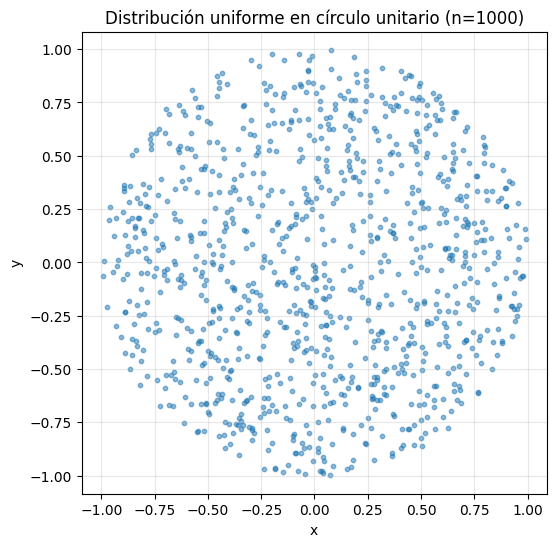

In [47]:
import numpy as np
import matplotlib.pyplot as plt

def generar_puntos_circulo_uniforme(n_puntos, radio=1.0):
    """
    Genera n_puntos distribuidos uniformemente en un círculo de radio dado.
    
    La clave es que el radio NO debe ser uniforme. Si r ~ U(0,1) 
    directamente, los puntos se concentran en el centro (menos área para radios pequeños).
    
    Solución: usar r = sqrt(U(0,1)) * radio
    Esto compensa el área menor que hay en radios pequeños.
    
    Luego: theta = U(0, 2π)
    Y convertir a cartesiano: x = r*cos(theta), y = r*sin(theta)
    """
    # ángulo uniforme en [0, 2π)
    theta = np.random.uniform(0, 2*np.pi, n_puntos)
    
    # radio: raíz cuadrada de uniforme [0,1], escalado por radio_deseado
    # La raíz cuadrada compensa la disminución del área al acercarse al origen
    r = np.sqrt(np.random.uniform(0, 1, n_puntos)) * radio
    
    # conversión a cartesiano
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    
    return np.column_stack((x, y))


n_muestras = 1000
puntos = generar_puntos_circulo_uniforme(n_muestras, radio=1.0)

# Visualizar
plt.figure(figsize=(6, 6))
plt.scatter(puntos[:, 0], puntos[:, 1], alpha=0.5, s=10)
plt.axis('equal')
plt.title(f'Distribución uniforme en círculo unitario (n={n_muestras})')
plt.grid(True, alpha=0.3)
plt.xlabel('x')
plt.ylabel('y')
plt.show()


Con la uniforme bien generada vamos a armar la clase que va a hacer todo el algoritmo para la red de Kohonen. 

In [50]:
class red_kohonen:
    def __init__(self, n_neuronas_x=1, n_neuronas_y=1, tasa_aprendizaje_inicial=0.1, n_iteraciones=100):
        """
        La idea es que admita datos de cualquier tipo pero los baja a 2D. 
        Los datos deben ser pasados en un array numpy de shape (n_muestras, n_features).
        Luego, la red de Kohonen tendrá una grilla de neuronas de tamaño (n_neuronas_x, n_neuronas_y).
        Y un vector de pesos en cada celda de la grilla, de tamaño (n_features,).
        Parámetros:
        - n_neuronas_x: número de neuronas en la dimensión x de la grilla
        - n_neuronas_y: número de neuronas en la dimensión y de la grilla
        - tasa_aprendizaje_inicial: tasa de aprendizaje inicial
        - n_iteraciones: número de iteraciones para el entrenamiento
        
        """
        self.n_neuronas_x = n_neuronas_x
        self.n_neuronas_y = n_neuronas_y
        self.tasa_aprendizaje_inicial = tasa_aprendizaje_inicial
        self.n_iteraciones = n_iteraciones
        self.matriz_neuronas = np.zeros((n_neuronas_x, n_neuronas_y, 2))
        
        # Pre-calcular grilla de coordenadas para las neuronas
        self.grid_x, self.grid_y = np.meshgrid(np.arange(n_neuronas_x), np.arange(n_neuronas_y), indexing='ij')
    
    def initialize_neurons(self, data):
        """
        Para inicializar las neuronas, podemos tomar puntos aleatorios del dataset.
        """
        n_muestras = data.shape[0]
        indices_aleatorios = np.random.choice(n_muestras, size=(self.n_neuronas_x * self.n_neuronas_y), replace=False)
        puntos_iniciales = data[indices_aleatorios]
        self.matriz_neuronas = puntos_iniciales.reshape((self.n_neuronas_x, self.n_neuronas_y, 2))
    
    def entrenar(self, data, varianza_vecindad=1.0):
        """
        Entrena la red de Kohonen con vectorización (mucho más rápido).
        """
        self.initialize_neurons(data)
        n_muestras = data.shape[0]
        
        for iteracion in range(self.n_iteraciones):
            tasa_aprendizaje = self.tasa_aprendizaje_inicial
            varianza_actual = varianza_vecindad * (1 - iteracion / self.n_iteraciones)
            
            # Barajamos los índices de las muestras
            indices = np.random.permutation(n_muestras)
            
            for i in indices:
                muestra = data[i]
                
                # Encontrar la neurona ganadora (BMU) - vectorizado
                distancias = np.linalg.norm(self.matriz_neuronas - muestra, axis=2)
                bmu_index = np.unravel_index(np.argmin(distancias), distancias.shape)
                
                # Calcular distancias en la grilla de forma vectorizada
                distancias_grilla = np.sqrt((self.grid_x - bmu_index[0])**2 + (self.grid_y - bmu_index[1])**2)
                
                # Función de vecindad gaussiana vectorizada
                h_ij = np.exp(-distancias_grilla**2 / (2 * varianza_actual**2))
                
                # Actualizar todos los pesos a la vez
                delta = tasa_aprendizaje * h_ij[..., np.newaxis] * (muestra - self.matriz_neuronas)
                self.matriz_neuronas += delta

"""
Los cambios principales son:

Pre-calcular la grilla de coordenadas (meshgrid) en el __init__ para evitar recalcularla cada iteración

Vectorizar el cálculo de distancias en la grilla usando NumPy arrays en lugar de bucles

Función gaussiana vectorizada calculada de una sola vez para todas las neuronas

Actualización vectorizada de todos los pesos con broadcasting: h_ij[..., np.newaxis] expande la dimensión para multiplicar correctamente

Shuffle de muestras para mejor convergencia estocástica

"""

'\nLos cambios principales son:\n\nPre-calcular la grilla de coordenadas (meshgrid) en el __init__ para evitar recalcularla cada iteración\n\nVectorizar el cálculo de distancias en la grilla usando NumPy arrays en lugar de bucles\n\nFunción gaussiana vectorizada calculada de una sola vez para todas las neuronas\n\nActualización vectorizada de todos los pesos con broadcasting: h_ij[..., np.newaxis] expande la dimensión para multiplicar correctamente\n\nShuffle de muestras para mejor convergencia estocástica\n\n'

In [52]:
# Entrenar la red de Kohonen con los puntos del círculo
red = red_kohonen(n_neuronas_x=5, n_neuronas_y=5, tasa_aprendizaje_inicial=0.1, n_iteraciones=1000)
red.entrenar(puntos, varianza_vecindad=4)

# Visualizar las neuronas después del entrenamiento
plt.figure(figsize=(8, 8))

# Graficar puntos del círculo
plt.scatter(puntos[:, 0], puntos[:, 1], alpha=0.3, s=10, label='Datos de entrada')

# Graficar neuronas
neuronas = red.matriz_neuronas.reshape(-1, 2)
plt.scatter(neuronas[:, 0], neuronas[:, 1], c='red', s=100, marker='o', edgecolors='black', linewidth=2, label='Neuronas')

# Conectar neuronas en la grilla para visualizar la topología
for i in range(red.n_neuronas_x):
    for j in range(red.n_neuronas_y - 1):
        plt.plot([red.matriz_neuronas[i, j, 0], red.matriz_neuronas[i, j+1, 0]], 
                 [red.matriz_neuronas[i, j, 1], red.matriz_neuronas[i, j+1, 1]], 'r-', alpha=0.5)

for i in range(red.n_neuronas_x - 1):
    for j in range(red.n_neuronas_y):
        plt.plot([red.matriz_neuronas[i, j, 0], red.matriz_neuronas[i+1, j, 0]], 
                 [red.matriz_neuronas[i, j, 1], red.matriz_neuronas[i+1, j, 1]], 'r-', alpha=0.5)

plt.axis('equal')
plt.title('Red de Kohonen después del entrenamiento')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


KeyboardInterrupt: 

Generando figuras geométricas...


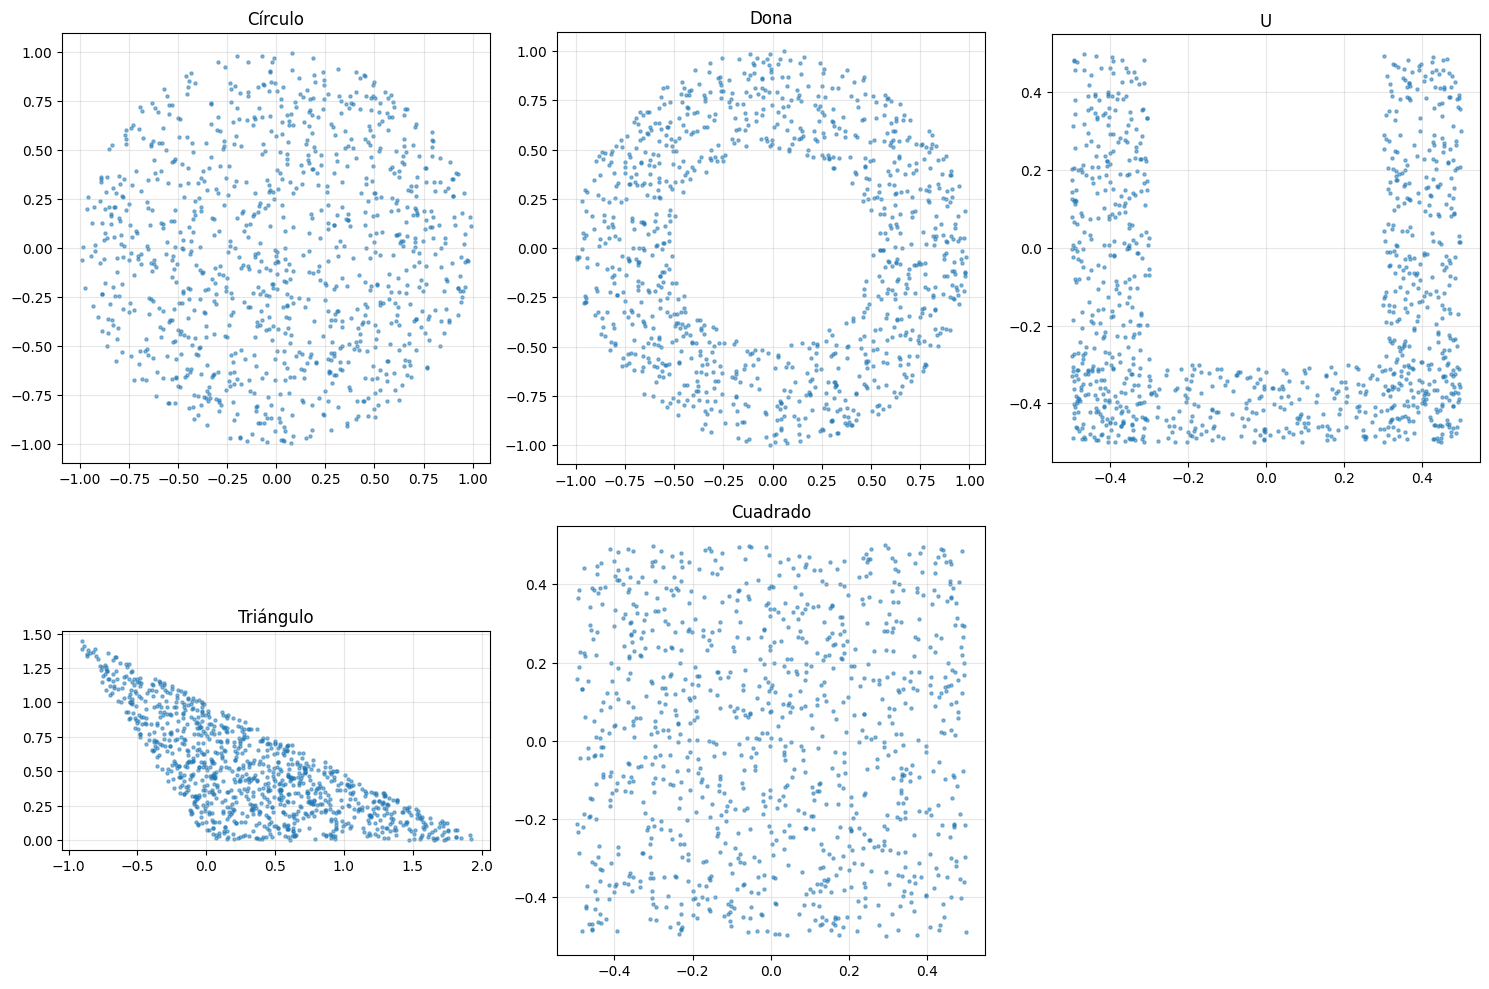

In [57]:
# Generar puntos en diferentes figuras geométricas

def generar_dona(n_puntos, radio_externo=1.0, radio_interno=0.5):
    """Genera puntos uniformes dentro de una dona (anillo)."""
    theta = np.random.uniform(0, 2*np.pi, n_puntos)
    # Para anillo uniforme: r = sqrt(u * (R_ext^2 - R_int^2) + R_int^2)
    u = np.random.uniform(0, 1, n_puntos)
    r = np.sqrt(u * (radio_externo**2 - radio_interno**2) + radio_interno**2)
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return np.column_stack((x, y))

def generar_u(n_puntos, ancho=0.3, altura=1.0):
    """Genera puntos en forma de U (dos rectángulos verticales conectados por uno horizontal)."""
    puntos = []
    
    # Rectángulo izquierdo vertical
    n1 = n_puntos // 3
    x_izq = np.random.uniform(-0.5, -0.5 + ancho, n1)
    y_izq = np.random.uniform(-altura/2, altura/2, n1)
    puntos.append(np.column_stack((x_izq, y_izq)))
    
    # Rectángulo derecho vertical
    n2 = n_puntos // 3
    x_der = np.random.uniform(0.5 - ancho, 0.5, n2)
    y_der = np.random.uniform(-altura/2, altura/2, n2)
    puntos.append(np.column_stack((x_der, y_der)))
    
    # Rectángulo horizontal en la base
    n3 = n_puntos - n1 - n2
    x_base = np.random.uniform(-0.5, 0.5, n3)
    y_base = np.random.uniform(-altura/2, -altura/2 + ancho, n3)
    puntos.append(np.column_stack((x_base, y_base)))
    
    return np.vstack(puntos)

def generar_triangulo(n_puntos, base=2.0, altura=1.5):
    """Genera puntos uniformes dentro de un triángulo."""
    # Usar barycentric coordinates para garantizar uniformidad
    r1 = np.random.uniform(0, 1, n_puntos)
    r2 = np.random.uniform(0, 1, n_puntos)
    
    # Cambio de coordenadas para que sea uniforme
    mask = r1 + r2 > 1
    r1[mask] = 1 - r1[mask]
    r2[mask] = 1 - r2[mask]
    
    # Vértices del triángulo: (0, 0), (base, 0), (base/2, altura)
    x = r1 * base + r2 * (base/2 - base)
    y = r2 * altura
    
    return np.column_stack((x, y))

def generar_cuadrado(n_puntos, lado=1.0):
    """Genera puntos uniformes dentro de un cuadrado."""
    x = np.random.uniform(-lado/2, lado/2, n_puntos)
    y = np.random.uniform(-lado/2, lado/2, n_puntos)
    return np.column_stack((x, y))

# Generar puntos para cada figura
print("Generando figuras geométricas...")
dona = generar_dona(n_muestras, radio_externo=1.0, radio_interno=0.5)
u = generar_u(n_muestras, ancho=0.2, altura=1.0)
triangulo = generar_triangulo(n_muestras, base=2.0, altura=1.5)
cuadrado = generar_cuadrado(n_muestras, lado=1.0)

# Visualizar todas las figuras
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

figuras = [
    (puntos, "Círculo"),
    (dona, "Dona"),
    (u, "U"),
    (triangulo, "Triángulo"),
    (cuadrado, "Cuadrado")
]

for idx, (pts, nombre) in enumerate(figuras):
    ax = axes[idx // 3, idx % 3]
    ax.scatter(pts[:, 0], pts[:, 1], alpha=0.5, s=5)
    ax.set_aspect('equal')
    ax.set_title(nombre)
    ax.grid(True, alpha=0.3)

# Ocultar el último subplot
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()



Entrenando red para: Círculo
Tiempo de entrenamiento: 59.85s
✓ Círculo COMPLETADO

Entrenando red para: Dona
Tiempo de entrenamiento: 59.85s
✓ Círculo COMPLETADO

Entrenando red para: Dona
Tiempo de entrenamiento: 61.17s
✓ Dona COMPLETADO

Entrenando red para: U
Tiempo de entrenamiento: 61.17s
✓ Dona COMPLETADO

Entrenando red para: U
Tiempo de entrenamiento: 58.20s
✓ U COMPLETADO

Entrenando red para: Triángulo
Tiempo de entrenamiento: 58.20s
✓ U COMPLETADO

Entrenando red para: Triángulo
Tiempo de entrenamiento: 59.52s
✓ Triángulo COMPLETADO

Entrenando red para: Cuadrado
Tiempo de entrenamiento: 59.52s
✓ Triángulo COMPLETADO

Entrenando red para: Cuadrado
Tiempo de entrenamiento: 58.98s
✓ Cuadrado COMPLETADO
Tiempo de entrenamiento: 58.98s
✓ Cuadrado COMPLETADO


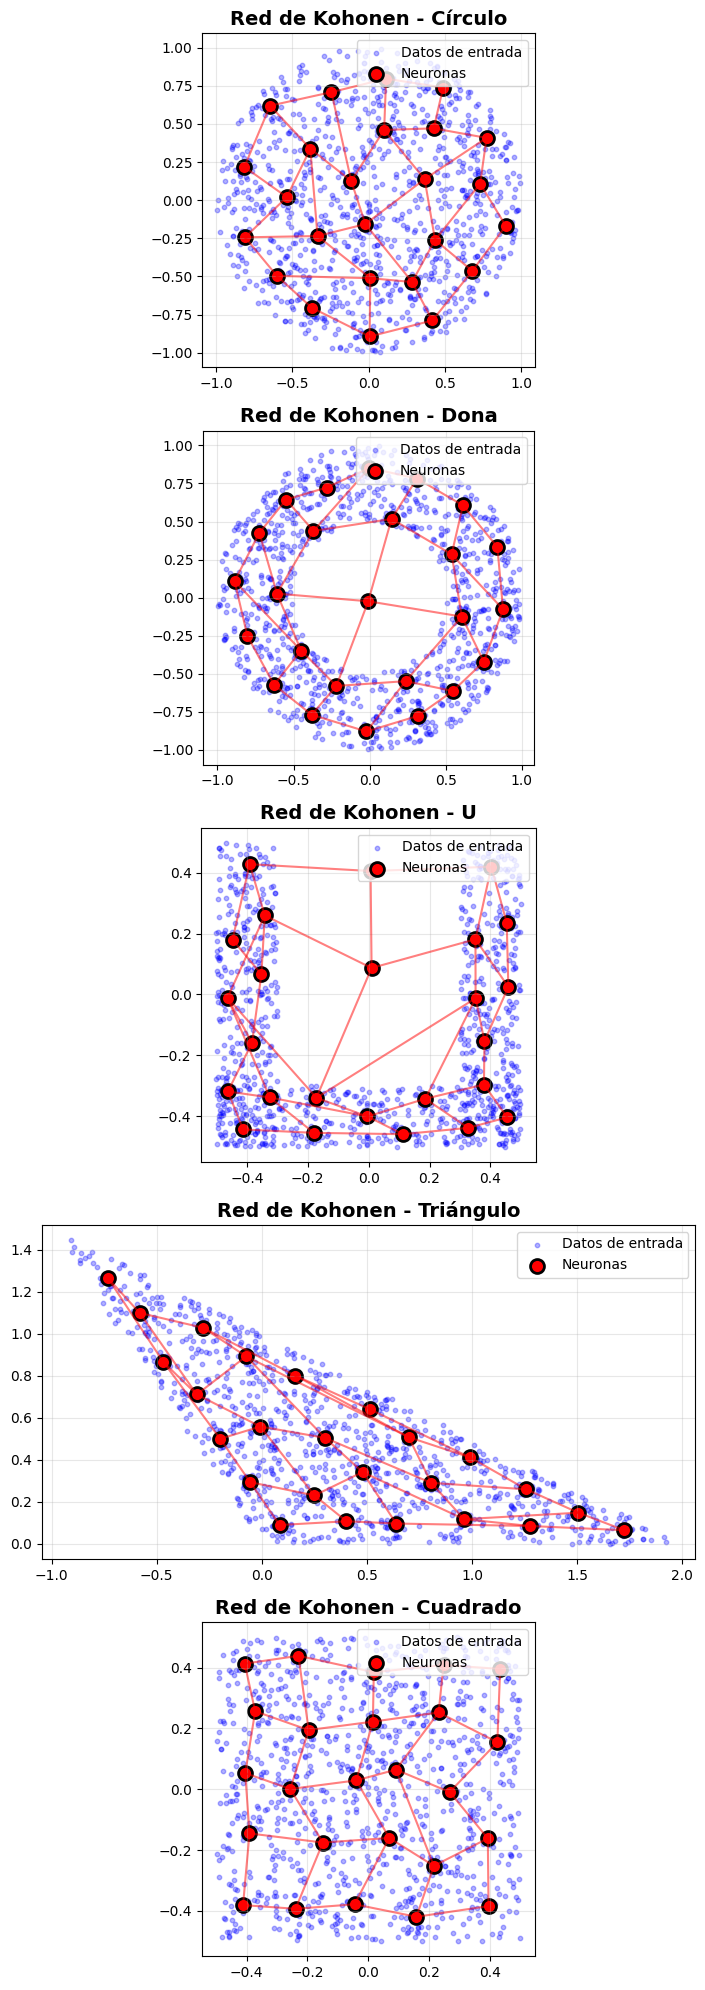


¡ENTRENAMIENTO DE TODAS LAS FIGURAS COMPLETADO!
Las redes están guardadas en: redes_entrenadas


In [ ]:
# Entrenar y guardar las redes para cada figura geométrica
import time

figuras_dataset = [
    (puntos, "Círculo"),
    (dona, "Dona"),
    (u, "U"),
    (triangulo, "Triángulo"),
    (cuadrado, "Cuadrado")
]

# Diccionario para guardar las redes entrenadas
redes_entrenadas = {}

fig, axes = plt.subplots(5, 1, figsize=(10, 20))

for idx, (datos, nombre) in enumerate(figuras_dataset):
    print(f"\n{'='*50}")
    print(f"Entrenando red para: {nombre}")
    print(f"{'='*50}")
    
    inicio = time.time()
    
    # Crear y entrenar la red
    red = red_kohonen(n_neuronas_x=5, n_neuronas_y=5, tasa_aprendizaje_inicial=0.1, n_iteraciones=500)
    red.entrenar(datos, varianza_vecindad=4)
    
    # Guardar la red entrenada
    redes_entrenadas[nombre] = red
    
    tiempo_entrenamiento = time.time() - inicio
    print(f"Tiempo de entrenamiento: {tiempo_entrenamiento:.2f}s")
    """
    # Visualizar
    ax = axes[idx]
    
    # Graficar puntos del dataset
    ax.scatter(datos[:, 0], datos[:, 1], alpha=0.3, s=10, label='Datos de entrada', color='blue')
    
    # Graficar neuronas
    neuronas = red.matriz_neuronas.reshape(-1, 2)
    ax.scatter(neuronas[:, 0], neuronas[:, 1], c='red', s=100, marker='o', edgecolors='black', linewidth=2, label='Neuronas')
    
    # Conectar neuronas en la grilla
    for i in range(red.n_neuronas_x):
        for j in range(red.n_neuronas_y - 1):
            ax.plot([red.matriz_neuronas[i, j, 0], red.matriz_neuronas[i, j+1, 0]], 
                   [red.matriz_neuronas[i, j, 1], red.matriz_neuronas[i, j+1, 1]], 'r-', alpha=0.5)
    
    for i in range(red.n_neuronas_x - 1):
        for j in range(red.n_neuronas_y):
            ax.plot([red.matriz_neuronas[i, j, 0], red.matriz_neuronas[i+1, j, 0]], 
                   [red.matriz_neuronas[i, j, 1], red.matriz_neuronas[i+1, j, 1]], 'r-', alpha=0.5)
    
    ax.set_aspect('equal')
    ax.set_title(f'Red de Kohonen - {nombre}', fontsize=14, fontweight='bold')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    """
    print(f"✓ {nombre} COMPLETADO")

plt.tight_layout()
plt.show()

print(f"\n{'='*50}")
print("¡ENTRENAMIENTO DE TODAS LAS FIGURAS COMPLETADO!")
print(f"Las redes están guardadas en: redes_entrenadas")
print(f"{'='*50}")


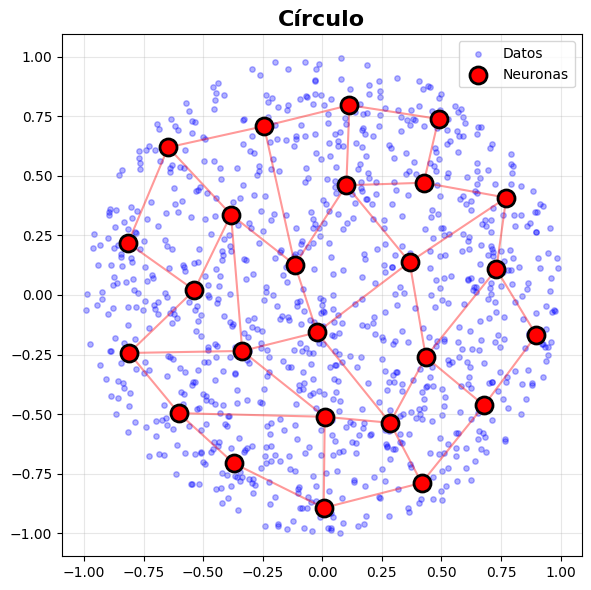

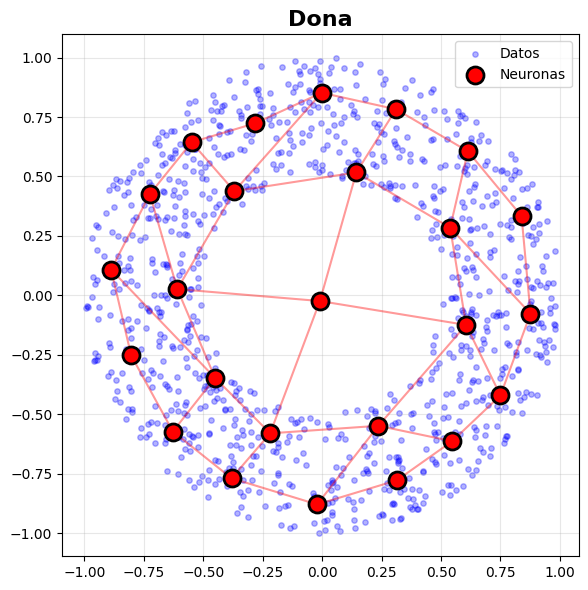

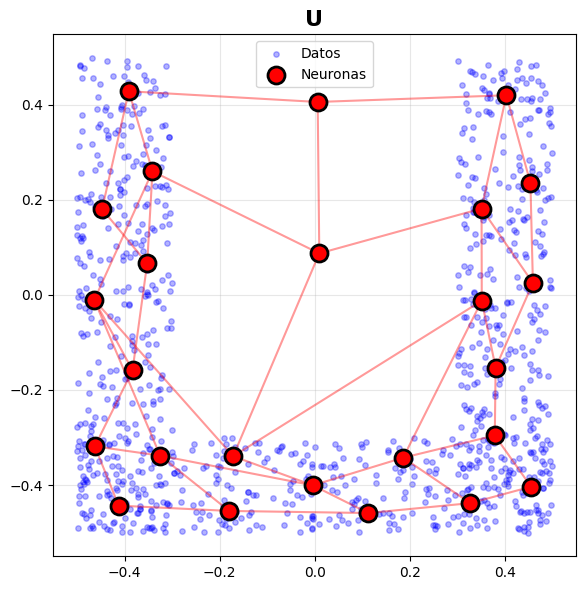

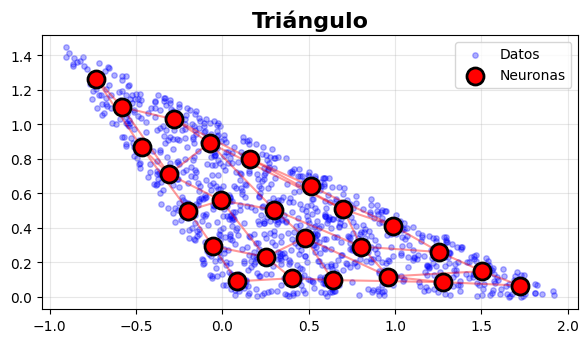

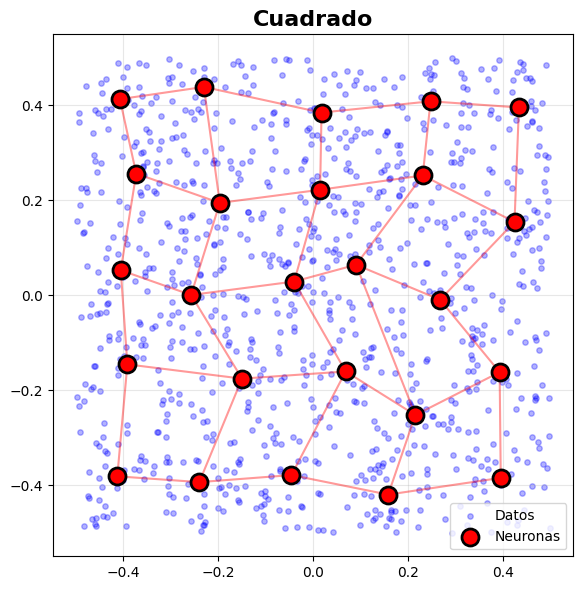


✓ Visualización individual de todas las redes completada


In [60]:
# Graficar cada red entrenada en figuras individuales
figuras_para_graficar = [
    (puntos, "Círculo"),
    (dona, "Dona"),
    (u, "U"),
    (triangulo, "Triángulo"),
    (cuadrado, "Cuadrado"),
]

for datos, nombre in figuras_para_graficar:
    # Obtener la red entrenada
    red = redes_entrenadas[nombre]

    plt.figure(figsize=(6, 6))

    # Graficar puntos del dataset
    plt.scatter(datos[:, 0], datos[:, 1], alpha=0.3, s=15, label='Datos', color='blue')

    # Graficar neuronas
    neuronas = red.matriz_neuronas.reshape(-1, 2)
    plt.scatter(neuronas[:, 0], neuronas[:, 1], c='red', s=150, marker='o',
                edgecolors='black', linewidth=2, label='Neuronas', zorder=5)

    # Conectar neuronas en la grilla
    for i in range(red.n_neuronas_x):
        for j in range(red.n_neuronas_y - 1):
            plt.plot([red.matriz_neuronas[i, j, 0], red.matriz_neuronas[i, j+1, 0]],
                     [red.matriz_neuronas[i, j, 1], red.matriz_neuronas[i, j+1, 1]],
                     'r-', alpha=0.4, linewidth=1.5)

    for i in range(red.n_neuronas_x - 1):
        for j in range(red.n_neuronas_y):
            plt.plot([red.matriz_neuronas[i, j, 0], red.matriz_neuronas[i+1, j, 0]],
                     [red.matriz_neuronas[i, j, 1], red.matriz_neuronas[i+1, j, 1]],
                     'r-', alpha=0.4, linewidth=1.5)

    ax = plt.gca()
    ax.set_aspect('equal')
    ax.set_title(f'{nombre}', fontsize=16, fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

print("\n✓ Visualización individual de todas las redes completada")